In [1]:
import numpy as np
np.set_printoptions(precision=2)

from mrobotics.piecewise.polyline import polyline
from projection_testing import test_projection, viz_projection
import matplotlib.pyplot as plt

In [2]:
mywaypoints = polyline(np.array([
    [-3.0,4.0],
    [0.0,0.0],
    [+4.0, 3.0],
    [6.0, 2.0]
]))

test_arclengths = np.linspace(-2.0, 15.0, 100) # a very dense sample

## A basic test (zeroth-order information)

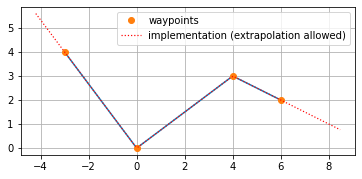

In [3]:
pts_test = mywaypoints.get_pos(test_arclengths)
_, ax = plt.subplots()
mywaypoints.viz(ax=ax)
ax.plot(*pts_test.T, ':r',lw=1.2, label='implementation (extrapolation allowed)')
ax.legend()
plt.show()

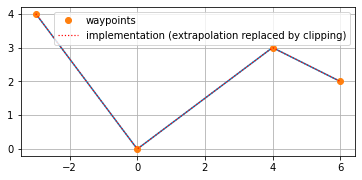

In [4]:
pts_test = mywaypoints.get_pos(mywaypoints.clip(test_arclengths))
_, ax = plt.subplots()
mywaypoints.viz(ax=ax)
ax.plot(*pts_test.T, ':r',lw=1.2, label='implementation (extrapolation replaced by clipping)')
ax.legend()
plt.show()

In [5]:
print("Inspect the breakpoint")
print(mywaypoints.idx2arclen)

Inspect the breakpoint
[ 0.    5.   10.   12.24]


## First-order information

In [6]:
def test_utang_batch(test_arclengths,**kwargs):
    assert test_arclengths.ndim == 1
    N = len(test_arclengths)
    unit_tangents = mywaypoints.get_utang(test_arclengths,**kwargs)
    for i in range(N):
        print("unit tangent at", f"{test_arclengths[i]:3.2f}".rjust(7), unit_tangents[i]) 
    np.testing.assert_allclose(np.linalg.norm(unit_tangents, axis=1, ord=2), 1.0)    

In [7]:
test_utang_batch(test_arclengths[::10])

unit tangent at   -2.00 [ 0.6 -0.8]
unit tangent at   -0.28 [ 0.6 -0.8]
unit tangent at    1.43 [ 0.6 -0.8]
unit tangent at    3.15 [ 0.6 -0.8]
unit tangent at    4.87 [ 0.6 -0.8]
unit tangent at    6.59 [0.8 0.6]
unit tangent at    8.30 [0.8 0.6]
unit tangent at   10.02 [ 0.89 -0.45]
unit tangent at   11.74 [ 0.89 -0.45]
unit tangent at   13.45 [ 0.89 -0.45]


In [8]:
# alternatively you can query one path parameter at a time.
for test_param in test_arclengths[::10]:
    print("unit tangent at", f"{test_param:3.2f}".rjust(7), mywaypoints.get_utang(mywaypoints.clip(test_param)))

unit tangent at   -2.00 [[ 0.6 -0.8]]
unit tangent at   -0.28 [[ 0.6 -0.8]]
unit tangent at    1.43 [[ 0.6 -0.8]]
unit tangent at    3.15 [[ 0.6 -0.8]]
unit tangent at    4.87 [[ 0.6 -0.8]]
unit tangent at    6.59 [[0.8 0.6]]
unit tangent at    8.30 [[0.8 0.6]]
unit tangent at   10.02 [[ 0.89 -0.45]]
unit tangent at   11.74 [[ 0.89 -0.45]]
unit tangent at   13.45 [[ 0.89 -0.45]]


## Add waypoints to extend the polyline path

In [9]:
mywaypoints.add(np.array([5,1]))

In [10]:
print("Inspect the breakpoint again (after adding the new point)")
mywaypoints.idx2arclen

Inspect the breakpoint again (after adding the new point)


array([ 0.  ,  5.  , 10.  , 12.24, 13.65])

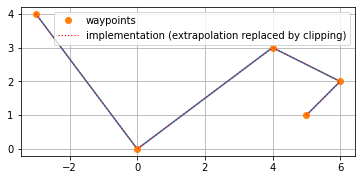

In [11]:
pts_test = mywaypoints.get_pos(mywaypoints.clip(test_arclengths))
_, ax = plt.subplots()
mywaypoints.viz(ax=ax)
ax.plot(*pts_test.T, ':r',lw=1.2, label='implementation (extrapolation replaced by clipping)')
ax.legend()
plt.show()

## Validate the query point projection
Find
$$
s^*(\vec q) 
\triangleq 
\text{ argmin}_{s \in \mathbb{R}} 
\| \vec q - \vec p(s) \|_2
= 
 \text{ argmin}_{s \in \mathbb{R}} 
\| \vec q - \vec p(s) \|^2_2
$$

where 

* $\vec q$ is the query point
* $\vec p(s)$ is the point of our parametric curve evaluated at $s$ (with extrapolation)
* $\hat n(s)$ is the unit normal of the parametric curve evaluated at $s$ (with extrapolation)


Instead of searching for the true globally.
We have a stateful computation:

* avoid abrupt changes in the arclength (to some extent, cf. the Padan et al. (2017) paper for an illustration).

* We might also prefer the local minimizer that is closer to the "previous path progress estimate" instead of the global minimum.

Be prepared! The following query point has 3 local minima!
------------------------------
finished iteration 0 with new iterate 9.400
finished iteration 1 with new iterate 9.400
init guess: 6.00, final iterate: 9.40, (signed) projected distance: -0.80, took 0.15 msec
------------------------------
finished iteration 0 with new iterate 10.447
finished iteration 1 with new iterate 10.447
init guess: 10.00, final iterate: 10.45, (signed) projected distance: -0.89, took 0.069 msec
------------------------------
finished iteration 0 with new iterate 13.650
finished iteration 1 with new iterate 13.650
init guess: 13.00, final iterate: 13.65, (signed) projected distance: -1.41, took 0.067 msec
------------------------------


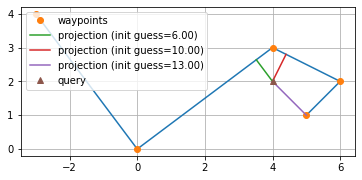

In [12]:
print("Be prepared! The following query point has 3 local minima!")
print("-"*30)
test_query = [4.0,2.0]
init_guess_list = (6.0, 10.0 , 13.0)
res_Frenet = test_projection(
    path_obj=mywaypoints,
    projection_method="project",
    test_query_pt= test_query, 
    expected_LHS=False,
    init_guess_list = init_guess_list,
    verbose=True
)
viz_projection(mywaypoints,test_query_pt=test_query,init_guess_list=init_guess_list, result_Frenet=res_Frenet)
plt.show()


Be prepared! The following query point has 2 local minima!
------------------------------
finished iteration 0 with new iterate 4.200
finished iteration 1 with new iterate 4.200
init guess: 2.00, final iterate: 4.20, (signed) projected distance: 0.60, took 0.26 msec
------------------------------
finished iteration 0 with new iterate 5.600
finished iteration 1 with new iterate 5.600
init guess: 6.00, final iterate: 5.60, (signed) projected distance: 0.80, took 0.14 msec
------------------------------


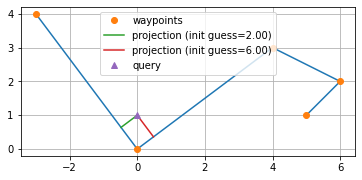

In [13]:
print("Be prepared! The following query point has 2 local minima!")
print("-"*30)
test_query = [0.0,1.0]
init_guess_list = (2.0, 6.0)
res_Frenet = test_projection(
    path_obj=mywaypoints,
    projection_method="project",
    test_query_pt= test_query, 
    expected_LHS=True,
    init_guess_list = init_guess_list,
    verbose=True
)
viz_projection(mywaypoints,test_query_pt=test_query,init_guess_list=init_guess_list, result_Frenet=res_Frenet)
plt.show()


In [14]:
# some perturbation to the query point
print(mywaypoints.project(np.array([-0.5,1.0]),arclength_init_guess=6.0)) # hang on to the 2nd segment
print(mywaypoints.project(np.array([-0.8,1.0]),arclength_init_guess=6.0)) # abrupt change!

(5.2, 1.1)
(3.7199999999999998, -0.040000000000000216)


# Sometimes the algorithm fails to converge

issue:

Suppose query point (Q) is very close to a waypoint (B). 
Let A and C be its precedessor and successor waypoints respectively. 
If the angle A-B-C is "too large", 
the projection algorithm will fail to the converged to the "desired level".

root cause:

A linear intepolated line has discontinuous change in the tangent at the waypoint/ breakpoints.
We can show that there is always a local sector around the waypoint (except when the three waypoints in question are collinear) in which the projected distance is NOT defined.
Limit cycle can be observed if your convergence tolerance is too tight.

how to work around:

* either use high-order interpolation (recommended)
* or replace the pointy/ "large curvature" waypoint with denser samples, each contributing to a lower curvature.
  This shall render the limit cycle during the projection so small that it is irrelevant which side the final iterate resides on.), e.g. see the example below.


In [15]:
xy_query = np.array([-0.01,-0.01])
init_guess = 6.0
# the first solution (choose the left side solution)
res1 = mywaypoints.project(xy_query,arclength_init_guess=init_guess, verbose=True, iter_max=3)
print("-"*20)
# the second solution (choose the right side solution)
res2 = mywaypoints.project(xy_query,arclength_init_guess=init_guess, verbose=True, iter_max=4)

finished iteration 0 with new iterate 4.986
finished iteration 1 with new iterate 5.002
finished iteration 2 with new iterate 4.986
--------------------
finished iteration 0 with new iterate 4.986
finished iteration 1 with new iterate 5.002
finished iteration 2 with new iterate 4.986
finished iteration 3 with new iterate 5.002


In [16]:
print(res1,res2)

(4.986, -0.002000000000000001) (5.002, -0.014000000000000089)


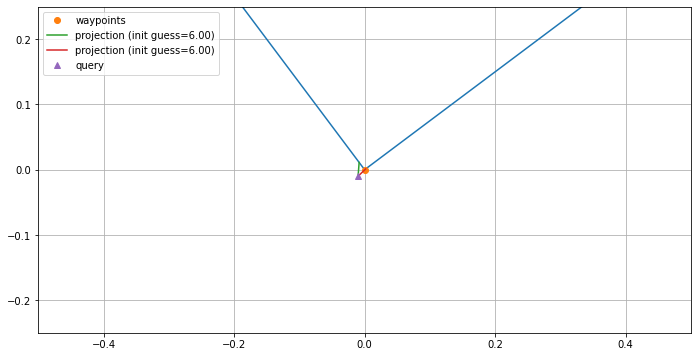

In [17]:
_, ax = plt.subplots(figsize=(12,6))
viz_projection(mywaypoints,test_query_pt=xy_query,init_guess_list=[init_guess]*2, result_Frenet=np.vstack((res1,res2)),ax=ax)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.25,0.25])
plt.show()